## Regression: predict fuel efficiency

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange).

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many models from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the tf.keras API, see this guide for details.

In [1]:
#Use seaborn for pairploat
!pip install -q seaborn

In [2]:
from __future__ import absolute_import, division, print_function

#Library
import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

C:\Users\home\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.0-dev20181220


## The Auto MPG dataset

The dataset is available from the UCI Machine Learning Repository.

### Get the data

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\home\\.keras\\datasets\\auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 

In [5]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values="?",
                          comment='\t', #Indicates remainder of line should not be parsed.
                          sep=" ", skipinitialspace=True) 

In [6]:
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Clean the data

The dataset contains a few unknown values.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

The "`Origin`" column is really categorical, not numeric. So convert that to a one-hot:

In [9]:
origin = dataset.pop('Origin')

In [10]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Split the data into train and test

Now split the data into a train and a test set.

We will use the test set in the final evaluation of out model.

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [12]:
print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


### Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

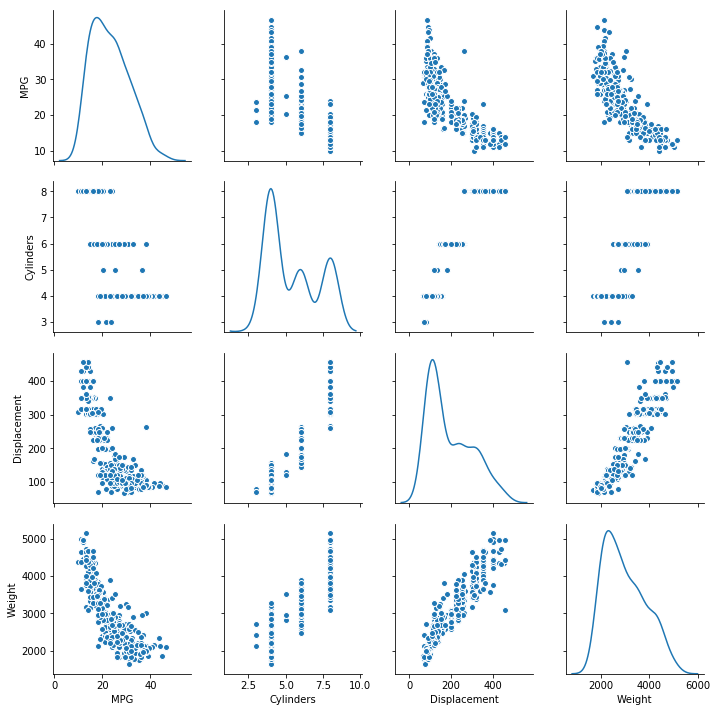

In [13]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [14]:
train_stats = train_dataset.describe()

In [15]:
train_stats

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.624204,0.178344,0.197452
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.485101,0.383413,0.398712
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [16]:
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [17]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges.
Although the model might converge without feature normalization, it make training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

** Note : That we intentionally use the statistics from only the training set, these statistics will also be used for evaluation. This is so that the model doesn't have any information about the test set.*

In [18]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [19]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


This normalized data is what we will use to train the model.

** Caution : The statistics used to normalize the inputs. here are as important as the model weights.*

## The model

### Build the model

Lets's bulid our model. Here, we'll use `Sequential` model with two densely connected hidden layers, and an output layer that return a single, continuous value. The model buliding step are wrapped in a function, `build_model`, since we'll create second model, later on.

In [21]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape = [len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
    
    model.compile(loss = tf.keras.losses.MSE,
                  optimizer= optimizer, 
                  metrics = ['mae', 'mse'])
    return model

In [22]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


### Inspect the model
Use the .summary method to print a simple description of the model

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [24]:
example_batch = normed_train_data[:10]
example_results = model.predict(example_batch)
example_results

array([[-0.30409512],
       [-0.36924255],
       [-0.03202812],
       [-0.894121  ],
       [-0.4664768 ],
       [ 0.02147128],
       [-0.5277203 ],
       [-0.66978836],
       [-0.04835995],
       [-0.3275395 ]], dtype=float32)

It seems to be working, it produces a result of the expected shape and type.

## Train the model

The model is trained for 1000 epochs, and record the training and validation accuracy in the history object.

In [25]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.476309,1.091354,2.476309,8.696625,2.275756,8.696626,995
996,2.406515,0.978326,2.406515,9.034015,2.305502,9.034015,996
997,2.207376,1.004066,2.207376,9.131279,2.342442,9.131279,997
998,2.433866,1.017387,2.433866,8.831593,2.305962,8.831594,998
999,2.273805,0.981760,2.273805,8.783705,2.297375,8.783705,999


In [27]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])

In [28]:
import matplotlib.pyplot as plt

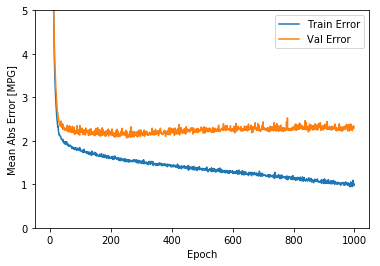

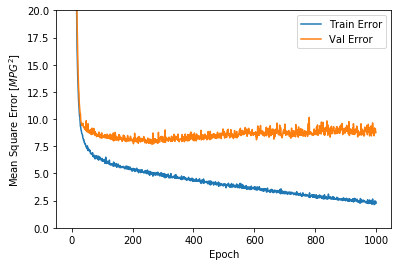

In [29]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,20])

plot_history(history)

In [30]:
def plt_history2(hist):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label="Train MAE ")
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label="Valid MAE")
    plt.ylim([0,5])
    plt.xlabel('epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(hist['epoch'], hist['mean_squared_error'], label="Train MSE ")
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label="Valid MSE")
    plt.xlabel('epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

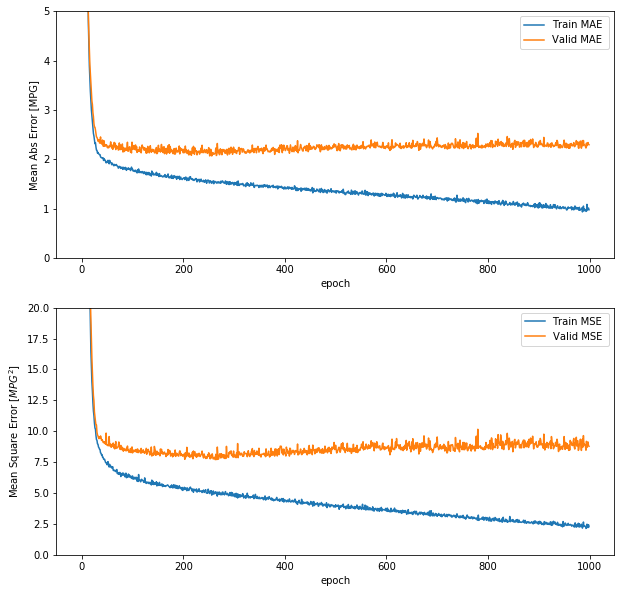

In [31]:
plt_history2(hist)

This graph shows little improvement, or even degradation in the validation error after a few hundred epochs. Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback
[here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=ko).

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [33]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
............................................................

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,587.591934,22.987595,587.591919,595.076471,23.096617,595.076538,0
1,556.085674,22.267590,556.085693,561.219277,22.326746,561.219238,1
2,522.775804,21.492834,522.775818,523.178840,21.428873,523.178833,2
3,484.568877,20.556234,484.568878,478.706395,20.328146,478.706421,3
4,440.800871,19.438177,440.800873,428.829977,19.030315,428.829987,4


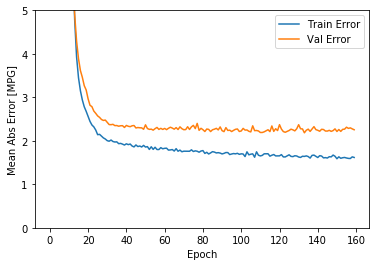

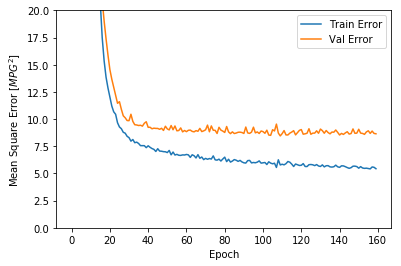

In [35]:
plot_history(hist)

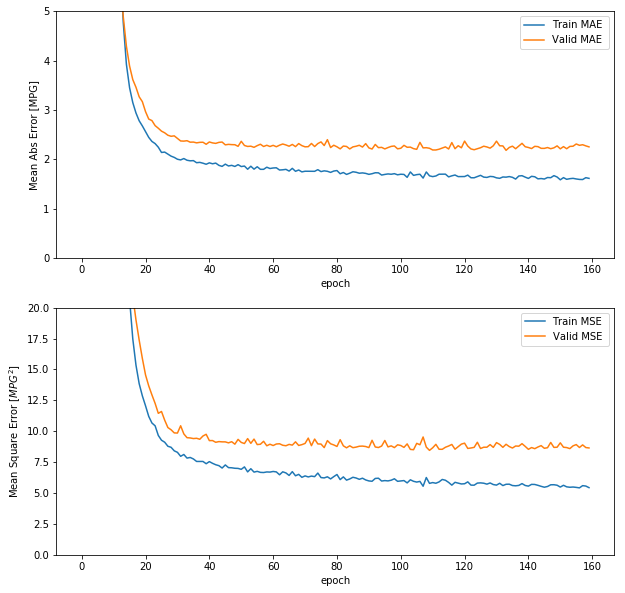

In [36]:
plt_history2(hist)

The graph shows that on the validation set, the average error usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how did the model performs on the test set, which we did not use when training the model:

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.88 MPG


## Make predictions
Finally, predict MPG values using data in the testing set:

In [38]:
model.predict(normed_test_data)

array([[15.842886],
       [10.75765 ],
       [11.142549],
       [23.60159 ],
       [21.35789 ],
       [13.03141 ],
       [13.057346],
       [12.829407],
       [19.76134 ],
       [29.299252],
       [25.492878],
       [23.539627],
       [14.704835],
       [28.08895 ],
       [12.79451 ],
       [14.358629],
       [14.456848],
       [13.346499],
       [18.440685],
       [13.272746],
       [14.813902],
       [26.100523],
       [19.552042],
       [20.618862],
       [28.965921],
       [24.458134],
       [17.148975],
       [21.566055],
       [17.949453],
       [18.150135],
       [26.82945 ],
       [22.728193],
       [18.785511],
       [20.805513],
       [26.821354],
       [16.354046],
       [18.836132],
       [29.862984],
       [29.842503],
       [18.202574],
       [30.104044],
       [28.002453],
       [15.66971 ],
       [36.501945],
       [35.303688],
       [35.554585],
       [20.79237 ],
       [22.549953],
       [20.362623],
       [24.65379 ],


In [39]:
test_predictions = model.predict(normed_test_data).flatten()

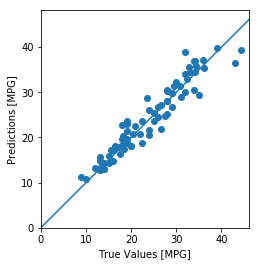

In [40]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

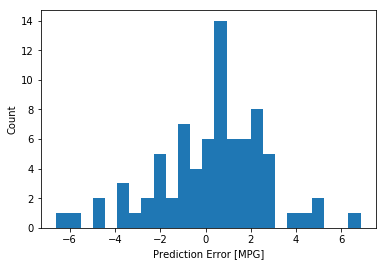

In [41]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Conclusion
This notebook introduced a few techniques to handle a regression problem.

* an Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
* milarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* en input data features have values with different ranges, each feature should be scaled independently.
*  there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* rly stopping is a useful technique to prevent overfitting.

In [42]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.